# Stock Prices Forecasting using LSTM

The stock prices forecast has always been a terrifying but complicated topic because stock market is typically very volatile. Reliable forecasts are linked to the opportunity to get good profit as a result of appropriate investments. A positive difference between the sold stock price and that of the purchased stock always means a gain in the capital.


In this notebook, I will look at how one can use the LSTM (Long Short Term memory) recurrent network model to predict the stock prices of the Apple and Intel companies. The future stock prices for a given company will be predicted solely based on the prices at the past moments of time for the same company. This approach should be viewed only as a starting point because it is clear that the prices depend on many factors that must be included in the datasets and incorporated in the predictive modeling.

First of all I import the necessary modules.

In [1]:
# import othe necessary modules

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

To ensure that the results are reproducible as much as possible, we must fix the seed values in the numpy and tensorflow generators and force tensorflow (that is now the basis of keras) to use single thread. The procedure below, though useful, significantly reduces randomness but does not get rid of it completely.

In [2]:

import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)


# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.random.set_seed(456)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

I also import the garbage collection module to clean memory when necessary.

In [3]:
#import the garbage collection module

import gc

gc.enable()

## Read and explore the data for Apple

We first read the Apple data from Yahoo! Finance webpage using the popular pandas_datareader tool and explore our dataset. We will use the data from 2008-02-29 to 2020-03-01 years inclusive. The dataset contains 3021 rows and no missing values.

In [4]:
import pandas_datareader as pdr
from datetime import datetime

aapl = pdr.get_data_yahoo(symbols='AAPL', start=datetime(2008, 2, 29), end=datetime(2020, 3, 1))

In [5]:
aapl.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2008-02-29,18.601429,17.828571,18.469999,17.860001,313870200.0,15.461356
2008-03-03,17.997143,16.857143,17.777143,17.389999,398260800.0,15.054481
2008-03-04,17.840000,17.200001,17.427143,17.802856,446345900.0,15.411883
2008-03-05,17.877142,17.464285,17.654285,17.784286,305459000.0,15.395814
2008-03-06,18.214285,17.258572,17.801428,17.275715,368424700.0,14.955544


In [6]:
aapl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3021 entries, 2008-02-29 to 2020-02-28
Data columns (total 6 columns):
High         3021 non-null float64
Low          3021 non-null float64
Open         3021 non-null float64
Close        3021 non-null float64
Volume       3021 non-null float64
Adj Close    3021 non-null float64
dtypes: float64(6)
memory usage: 165.2 KB


In [7]:
aapl.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

For simplicity, we will focus only on the 'Close' stock prices column and drop all other columns. One can see that the stock prices rose significantly starting from 2008. The overall standard deviation is also quite high.

In [8]:
aapl = aapl.drop(['High', 'Low', 'Open', 'Volume', 'Adj Close'], axis = 1)

gc.collect()

50

In [9]:
aapl.describe()

,Close
count,3021.000000
mean,99.201959
std,65.467066
min,11.171429
25%,48.014286
50%,88.675713
75%,137.110001
max,327.200012


C:\Users\ddali\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


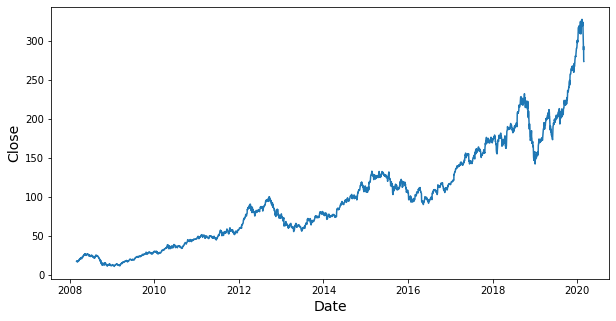

In [10]:
plt.figure(figsize=(10,5))

plt.plot(aapl)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Close', fontsize = 14)
plt.show()

### Augmented Dickey-Fuller tests

We now run the augmented Dickey-Fuller (DF) test on the data. The test is designed to determine whether the time series describing the stock prices is stationary or not. The null-hypothesis states that the series is non-stationary. High p-value means that null-hypothesis should NOT be rejected.

In [11]:
from statsmodels.tsa.stattools import adfuller

C:\Users\ddali\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [12]:
p_val = adfuller(aapl['Close'].values,  regression='ctt', 
                                autolag='AIC', maxlag =5)[1]

print('The ADF test p-value applied to Apple stock prices is:', p_val)

The ADF test p-value applied to Apple stock prices is: 0.4176372401295928


One can see that our original time series representing stock prices is highly non-stationary. This is not surprising because, as follows from the plot above, the trend towards price increase is very strong. Let's create the column with differences in prices related to neighboring dates (y_{t+1} - y_t). 

In [13]:
aapl['Close_diff']  = aapl['Close'].diff().fillna(0)

aapl.head()

,Close,Close_diff
Date,,
2008-02-29,17.860001,0.000000
2008-03-03,17.389999,-0.470001
2008-03-04,17.802856,0.412857
2008-03-05,17.784286,-0.018570
2008-03-06,17.275715,-0.508572


Applying ADF to the time series made of first differences, we see that the relevant p-value is indistinguishable from 0, meaning that this time series can be regarded stationary.

In [14]:
p_val = adfuller(aapl['Close_diff'].values,  regression='ctt', 
                                autolag='AIC', maxlag =5)[1]

print('The ADF test p-value applied to the time series of first differences is:', p_val)

The ADF test p-value applied to the time series of first differences is: 0.0


In [15]:
aapl.describe()

,Close,Close_diff
count,3021.000000,3021.000000
mean,99.201959,0.084575
std,65.467066,1.926719
min,11.171429,-19.130005
25%,48.014286,-0.570000
50%,88.675713,0.067142
75%,137.110001,0.781429
max,327.200012,11.210007


In [16]:
gc.collect()

2525

## Predictive modelling for Apple

Let us try to predict the close stock prices of the Apple company and measure how close we came to the actual values. We will apply the Long Short Term Memory (LSTM) RNN model and use the data before 2019-03-01 for training. To test the machine learning model, we use the data after that date. We will be working only with the prices from the 'Close' column. The test data span the period of one year which is quite large. This large period of time reserved for testing, will allow us to see until what moment of time the predictions can be considered more or less reliable. The test data, however, comprise roughly 8.3 percent of the total data.

In [17]:
print('The total number of entries is:', len(aapl.index))

The total number of entries is: 3021


In [18]:
aapl_train = aapl[aapl.index < '2019-03-01']

aapl_test =  aapl[aapl.index >= '2019-03-01']

print("Training set size: ",aapl_train.index.size)
print("Test set size: ", aapl_test.index.size)

Training set size:  2769
Test set size:  252


Not only because the stock prices vary dramatically, but also aiming to increase the accuracy, we will scale the data using StandardScaler. Only training data will be used for fitting the scaler. It has been checked that using StandardScaler is more preferable than MinMaxScaler.

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


scaler = StandardScaler()

scaler.fit(aapl_train[['Close']])

aapl_train['Close_scaled'] = scaler.transform(aapl_train[['Close']])


C:\Users\ddali\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
aapl_test['Close_scaled'] = scaler.transform(aapl_test[['Close']])

C:\Users\ddali\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
aapl_train.tail()

,Close,Close_diff,Close_scaled
Date,,,
2019-02-22,172.970001,1.910004,1.639082
2019-02-25,174.229996,1.259995,1.663140
2019-02-26,174.330002,0.100006,1.665049
2019-02-27,174.869995,0.539993,1.675359
2019-02-28,173.149994,-1.720001,1.642519


### Timestep data creation 

The recurrent network has memory which is maintained by fixing the so-called time step (TIMESTEP variable). We have to present X_train and X_test in the three-dimensional form (number of samples, TIMESTEP, 1) in accordance with the input requirements for recurrent neural networks. The time step tells us how many steps back in time backpropagation uses when
calculating gradients for weight updates during training. The TIMESTEP is a hyperpatameter of the model, and we decided to choose its value equal to 10. In fact, relatively small values of the TIMESTEP seem to be more suitable.

In [22]:
TIMESTEP = 10 # number of timesteps in the sequence

We then define a function in which some dataset along with the time step are the input variables. It returns the input and output data. The input data consists of intervals each having the size of TIMESTEP. The output data is an array comprised of prices at the moments of time next with respect to the end of each input interval.   

In [23]:
def DatasetCreation(dataset, timestep):
    
    X, y = [], []
    
    for i in range(len(dataset)- timestep):
        a = dataset[i:(i+ timestep)]
        X.append(a)
        y.append(dataset[i + timestep])
    
    return np.array(X), np.array(y)

We then create the train dataset X_train and y_train using the function defined above and reshape our arrays according to the form necessary for the input layer.

In [24]:
X_train, y_train = DatasetCreation(np.array(aapl_train.Close_scaled), TIMESTEP)
 
#reshape training set according to the form specified above     
X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEP, 1))  

# add extra dimension to y
y_train = np.expand_dims(y_train, axis=1)


In [25]:
print(X_train.shape,  y_train.shape)

(2759, 10, 1) (2759, 1)


Creating the test set, we must take into account also the latest values from the training set. The test data will in fact contain some overlap with the training data. The size of this overlap is exactly given by TIMESTEPS.

In [26]:
inputs = pd.concat([aapl_train['Close_scaled'], aapl_test['Close_scaled']], axis =0)\
         .iloc[len(aapl.index) - len(aapl_test.index)-TIMESTEP:]

X_test, y_test = DatasetCreation(np.array(inputs), TIMESTEP)
 
#reshape test set according to the form specified above     
X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEP, 1))  

# add extra dimension to y
y_test = np.expand_dims(y_test, axis=1)


In [27]:
print(X_test.shape,  y_test.shape)

(252, 10, 1) (252, 1)


###  LSTM model for Apple

We will use the sequential Recurrent Neural Network architecture consisting of three LSTM layers with 80 nodes each. The number of nodes in each layer is a hyperparameter that requires time to tune.

In [28]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from keras.initializers import Orthogonal, glorot_uniform

Using TensorFlow backend.


In [29]:
HIDDEN_SIZE = 80 # number of the elements in the hidden layer to serve as hyperparameter


model = Sequential()   
model.add(LSTM(HIDDEN_SIZE, activation = 'tanh', input_shape=(TIMESTEP, 1), 
               kernel_initializer = glorot_uniform(seed=123), 
               recurrent_initializer = Orthogonal(seed=123),
                       return_sequences = True))



model.add(LSTM(HIDDEN_SIZE, activation = 'tanh', kernel_initializer = glorot_uniform(seed=123), 
               recurrent_initializer = Orthogonal(seed=123), return_sequences = True))


model.add(LSTM(HIDDEN_SIZE, activation = 'tanh', kernel_initializer = glorot_uniform(seed=123), 
               recurrent_initializer = Orthogonal(seed=123), return_sequences = False))


model.add(Dense(1, kernel_initializer=glorot_uniform(seed=123)))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 80)            26240     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 80)            51520     
_________________________________________________________________
lstm_3 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 81        
Total params: 129,361
Trainable params: 129,361
Non-trainable params: 0
_________________________________________________________________


To compile, we use the 'RMSprop' optimizer. The initial learning rate as well as its decay rate need to be fine-tuned as well, which is a time-consuming process. The initial learning rate INITIAL_LR is chosen equal to 0.0035, and the learning rate itself will decay with each epoch according to the formula INITIAL_LR * 0.97 ** epoch. The mean-squared error (MSE) will be chosen as a loss that will also serve as our metrics.

In [30]:
from keras.optimizers import RMSprop

#initial learning rate
INITIAL_LR = 0.0025

OPTIMIZER = RMSprop(lr=INITIAL_LR)

model.compile(loss='mean_squared_error', optimizer= OPTIMIZER, metrics = ['mse'])

Finally, we need to choose the number of epochs, as well as the batch size. It is found that one can train the model during 450 epochs and take batch size equal to 32. Further increasing the number of epochs and decreasing the batch size becomes time consuming and may affect the stability of training process. We will use ModelCheckpoint to save only the weights leading to the lowest mean squared error in the process of training. 

In [31]:
# learning rate decay
def lr_decay(epoch):
    return INITIAL_LR * 0.97 ** epoch


checkpoint = ModelCheckpoint('model_apple_weights.h5', monitor='mse', 
                            verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint, LearningRateScheduler(lr_decay)]

In [32]:
%%time

NUM_EPOCHS = 450  # number of epochs

BATCH_SIZE =  32  # batch size

VERBOSE = 1

# !!!it is important that we do not shuffle data

history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=False, 
                                  verbose = VERBOSE, callbacks = callbacks_list)

Epoch 1/450
2759/2759 [==============================] - 6s 2ms/step - loss: 0.1802 - mse: 0.1802

Epoch 00001: mse improved from inf to 0.18023, saving model to model_apple_weights.h5
Epoch 2/450
2759/2759 [==============================] - 5s 2ms/step - loss: 0.0679 - mse: 0.0679

Epoch 00002: mse improved from 0.18023 to 0.06788, saving model to model_apple_weights.h5
Epoch 3/450
2759/2759 [==============================] - 4s 1ms/step - loss: 0.0372 - mse: 0.0372

Epoch 00003: mse improved from 0.06788 to 0.03722, saving model to model_apple_weights.h5
Epoch 4/450
2759/2759 [==============================] - 4s 1ms/step - loss: 0.0286 - mse: 0.0286

Epoch 00004: mse improved from 0.03722 to 0.02859, saving model to model_apple_weights.h5
Epoch 5/450
2759/2759 [==============================] - 4s 1ms/step - loss: 0.0251 - mse: 0.0251

Epoch 00005: mse improved from 0.02859 to 0.02515, saving model to model_apple_weights.h5
Epoch 6/450
2759/2759 [==============================] - 4s

Epoch 45/450
2759/2759 [==============================] - 4s 2ms/step - loss: 0.0026 - mse: 0.0026

Epoch 00045: mse did not improve from 0.00256
Epoch 46/450
2759/2759 [==============================] - 4s 2ms/step - loss: 0.0024 - mse: 0.0024A: 0s - loss: 0.0013 - m

Epoch 00046: mse improved from 0.00256 to 0.00239, saving model to model_apple_weights.h5
Epoch 47/450
2759/2759 [==============================] - 5s 2ms/step - loss: 0.0024 - mse: 0.0024A: 1s - l

Epoch 00047: mse did not improve from 0.00239
Epoch 48/450
2759/2759 [==============================] - 4s 2ms/step - loss: 0.0022 - mse: 0.0022

Epoch 00048: mse improved from 0.00239 to 0.00222, saving model to model_apple_weights.h5
Epoch 49/450
2759/2759 [==============================] - 4s 2ms/step - loss: 0.0022 - mse: 0.0022

Epoch 00049: mse did not improve from 0.00222
Epoch 50/450
2759/2759 [==============================] - 4s 2ms/step - loss: 0.0021 - mse: 0.0021

Epoch 00050: mse improved from 0.00222 to 0.00212

2759/2759 [==============================] - 4s 2ms/step - loss: 0.0011 - mse: 0.0011    - ETA: 0s - loss: 6.1123e-04 -

Epoch 00091: mse improved from 0.00107 to 0.00107, saving model to model_apple_weights.h5
Epoch 92/450
2759/2759 [==============================] - 4s 1ms/step - loss: 0.0011 - mse: 0.0011  

Epoch 00092: mse improved from 0.00107 to 0.00106, saving model to model_apple_weights.h5
Epoch 93/450
2759/2759 [==============================] - 4s 2ms/step - loss: 0.0011 - mse: 0.0011   

Epoch 00093: mse improved from 0.00106 to 0.00106, saving model to model_apple_weights.h5
Epoch 94/450
2759/2759 [==============================] - 4s 2ms/step - loss: 0.0011 - mse: 0.0011   

Epoch 00094: mse improved from 0.00106 to 0.00105, saving model to model_apple_weights.h5
Epoch 95/450
2759/2759 [==============================] - 5s 2ms/step - loss: 0.0010 - mse: 0.0010   

Epoch 00095: mse improved from 0.00105 to 0.00105, saving model to model_apple_weights.h5
Epoch 96/450
2759/

Epoch 135/450
2759/2759 [==============================] - 3s 1ms/step - loss: 0.0010 - mse: 0.0010    

Epoch 00135: mse improved from 0.00100 to 0.00100, saving model to model_apple_weights.h5
Epoch 136/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.9978e-04 - mse: 9.9978e-04

Epoch 00136: mse improved from 0.00100 to 0.00100, saving model to model_apple_weights.h5
Epoch 137/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.9930e-04 - mse: 9.9930e-04

Epoch 00137: mse improved from 0.00100 to 0.00100, saving model to model_apple_weights.h5
Epoch 138/450
2759/2759 [==============================] - 5s 2ms/step - loss: 9.9883e-04 - mse: 9.9883e-04

Epoch 00138: mse improved from 0.00100 to 0.00100, saving model to model_apple_weights.h5
Epoch 139/450
2759/2759 [==============================] - 4s 2ms/step - loss: 9.9836e-04 - mse: 9.9836e-04A: 0s - loss: 9.4167e-04 - mse: 9.4167e-

Epoch 00139: mse improved from 0.00100 to 0.00100, saving m

2759/2759 [==============================] - 3s 1ms/step - loss: 9.8602e-04 - mse: 9.8602e-04

Epoch 00176: mse improved from 0.00099 to 0.00099, saving model to model_apple_weights.h5
Epoch 177/450
2759/2759 [==============================] - 3s 1ms/step - loss: 9.8579e-04 - mse: 9.8579e-04

Epoch 00177: mse improved from 0.00099 to 0.00099, saving model to model_apple_weights.h5
Epoch 178/450
2759/2759 [==============================] - 3s 1ms/step - loss: 9.8556e-04 - mse: 9.8556e-04

Epoch 00178: mse improved from 0.00099 to 0.00099, saving model to model_apple_weights.h5
Epoch 179/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.8534e-04 - mse: 9.8534e-04

Epoch 00179: mse improved from 0.00099 to 0.00099, saving model to model_apple_weights.h5
Epoch 180/450
2759/2759 [==============================] - 3s 1ms/step - loss: 9.8513e-04 - mse: 9.8513e-04

Epoch 00180: mse improved from 0.00099 to 0.00099, saving model to model_apple_weights.h5
Epoch 181/450
2759/

2759/2759 [==============================] - 4s 1ms/step - loss: 9.8028e-04 - mse: 9.8028e-04

Epoch 00217: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 218/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.8020e-04 - mse: 9.8020e-04

Epoch 00218: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 219/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.8012e-04 - mse: 9.8012e-04

Epoch 00219: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 220/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.8004e-04 - mse: 9.8004e-04

Epoch 00220: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 221/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.7996e-04 - mse: 9.7996e-04

Epoch 00221: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 222/450
2759/

Epoch 258/450
2759/2759 [==============================] - 4s 2ms/step - loss: 9.7787e-04 - mse: 9.7787e-04

Epoch 00258: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 259/450
2759/2759 [==============================] - 4s 2ms/step - loss: 9.7783e-04 - mse: 9.7783e-04A: 2s - los

Epoch 00259: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 260/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.7780e-04 - mse: 9.7780e-04

Epoch 00260: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 261/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.7776e-04 - mse: 9.7776e-04

Epoch 00261: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 262/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.7773e-04 - mse: 9.7773e-04

Epoch 00262: mse improved from 0.00098 to 0.00098, saving model to model_apple_weigh

Epoch 299/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.7699e-04 - mse: 9.7699e-04

Epoch 00299: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 300/450
2759/2759 [==============================] - 4s 2ms/step - loss: 9.7698e-04 - mse: 9.7698e-04

Epoch 00300: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 301/450
2759/2759 [==============================] - 5s 2ms/step - loss: 9.7697e-04 - mse: 9.7697e-04

Epoch 00301: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 302/450
2759/2759 [==============================] - 5s 2ms/step - loss: 9.7696e-04 - mse: 9.7696e-04

Epoch 00302: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 303/450
2759/2759 [==============================] - 5s 2ms/step - loss: 9.7695e-04 - mse: 9.7695e-04

Epoch 00303: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch

2759/2759 [==============================] - ETA: 0s - loss: 9.7779e-04 - mse: 9.7779e-0 - 4s 1ms/step - loss: 9.7672e-04 - mse: 9.7672e-04

Epoch 00340: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 341/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.7672e-04 - mse: 9.7672e-04

Epoch 00341: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 342/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.7672e-04 - mse: 9.7672e-04

Epoch 00342: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 343/450
2759/2759 [==============================] - 4s 2ms/step - loss: 9.7672e-04 - mse: 9.7672e-04A: 2s - 

Epoch 00343: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 344/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.7671e-04 - mse: 9.7671e-04

Epoch 00344: mse improved from 0.00098 to 0.00098, savi

Epoch 381/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.7665e-04 - mse: 9.7665e-04

Epoch 00381: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 382/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.7665e-04 - mse: 9.7665e-04

Epoch 00382: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 383/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.7665e-04 - mse: 9.7665e-04

Epoch 00383: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 384/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.7665e-04 - mse: 9.7665e-04

Epoch 00384: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 385/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.7665e-04 - mse: 9.7665e-04

Epoch 00385: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch

2759/2759 [==============================] - 4s 1ms/step - loss: 9.7663e-04 - mse: 9.7663e-04

Epoch 00423: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 424/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.7663e-04 - mse: 9.7663e-04

Epoch 00424: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 425/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.7663e-04 - mse: 9.7663e-04

Epoch 00425: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 426/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.7663e-04 - mse: 9.7663e-04

Epoch 00426: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 427/450
2759/2759 [==============================] - 4s 1ms/step - loss: 9.7663e-04 - mse: 9.7663e-04

Epoch 00427: mse improved from 0.00098 to 0.00098, saving model to model_apple_weights.h5
Epoch 428/450
2759/

Let's evaluate our model first on the train set and plot the behavior of the loss as a function of epoch number.

In [33]:
score = model.evaluate(X_train, y_train, verbose=0)
print('Keras Model Loss = ',score[0])

Keras Model Loss =  0.000976615721042882


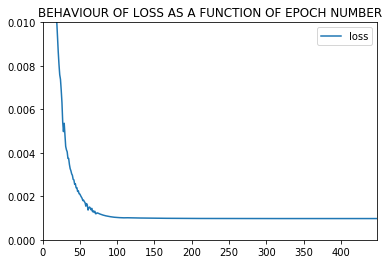

In [34]:
metrics_df = pd.DataFrame(data={"loss": history.history['loss']})
#metrics_df

fig1 = metrics_df.plot(title ='BEHAVIOUR OF LOSS AS A FUNCTION OF EPOCH NUMBER',
                      ylim = (0, 0.01)).\
get_figure()

plt.show()

fig1.savefig('loss_apple.pdf')

### Predictions using the test set and comparison with the actual prices for Apple

We now make predictions and plot the results. Making the predictions and comparing with real values, we must make the so-called prediction shift, shifting our predictions by one moment of time back. 

In [35]:
y_pred = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred)
y_pred = np.squeeze(y_pred, axis = 1)

y_pred.shape

(252,)

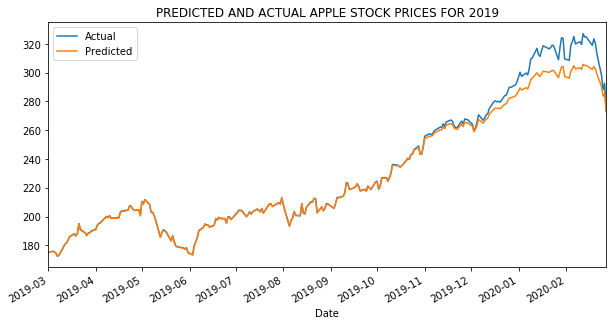

In [36]:
ind = aapl_test.index

pred_df = pd.DataFrame(data={'Actual': aapl_test['Close'][:-1], 
                                    'Predicted': y_pred[1:]}, index = ind[:-1])

fig2 = pred_df.plot(figsize=(10,5),
                    title = 'PREDICTED AND ACTUAL APPLE STOCK PRICES FOR 2019').get_figure()
plt.show()

fig2.savefig('predicted_prices_apple.pdf')

We also plot the accuracy of our predictions in order to visualize how the predicted prices compare to the actual ones. 

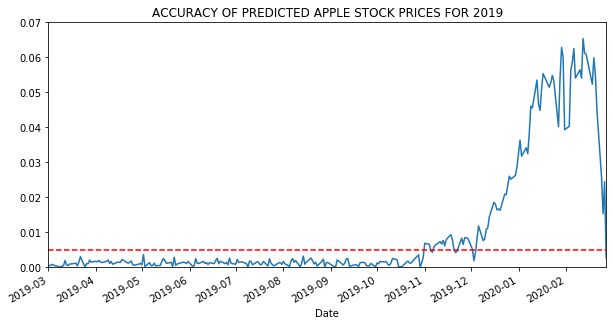

In [37]:
pred_df['Accuracy'] = np.abs(pred_df['Actual'] - \
                                    pred_df['Predicted'])/pred_df['Actual']

fig3 = pred_df['Accuracy'].plot(title = 'ACCURACY OF PREDICTED APPLE STOCK PRICES FOR 2019', 
                                  figsize=(10,5), ylim = (0, 0.07)).get_figure()

plt.axhline(y=.005, ls = 'dashed', c = 'r')

plt.show()

fig3.savefig('accuracy_of_prediction_apple.pdf')

We see that our model is able to predict the Apple prices during the first 8 months quite well. In fact, the predicted prices differ from the actual ones by not more than 0.5 percent, which is a decent result given that the predictions were made based on the history of prices alone. After 8 months the reliability of predictions sharply decreases, albeit even there the shape of the curve for predicted prices qualitatively follows that for the actual price regarding peaks and dips. 
All this suggests that the properly trained RNNs can be a powerful tool that can used in making stock price predictions.

In [38]:
gc.collect()

80

## Predictive modelling for Intel

Here we will use the same model comprised of LSTM layers and try to predict the stock prices of Intel. The training and test sets will be based on the same time segments as for Apple. It can be seen from below that the scale of stock prices for Intel is much smaller compared to that for Apple. However, the general tendency towards price increase with time is noticeable here as well. One observes also that the Intel stock prices are noisier than those for Apple. In other words, these prices are more volatile and undergo noticeable fluctuations within relatively small intervals of time.   

In [39]:
intel = pdr.get_data_yahoo(symbols='INTC', start=datetime(2008, 2, 29), end=datetime(2020, 3, 1))

In [40]:
intel = intel.drop(['High', 'Low', 'Open', 'Volume', 'Adj Close'], axis = 1)

gc.collect()

48

In [41]:
intel.describe()

,Close
count,3021.000000
mean,30.712870
std,11.722894
min,12.080000
25%,21.540001
50%,26.889999
75%,36.180000
max,68.470001


In [42]:
#Augmented Dicke-Fuller test

p_val = adfuller(intel['Close'].values,  regression='ctt', 
                                autolag='AIC', maxlag =5)[1]

print('The ADF test p-value applied to Intel stock prices is:', p_val)

The ADF test p-value applied to Intel stock prices is: 0.009252973345303039


We also see that the augmented Dicke-Fuller test leads to the p-value equal to 0.00925 which is quite small suggesting that the null-hypothesis should be rejected and the time series can be considered approximately stationary.

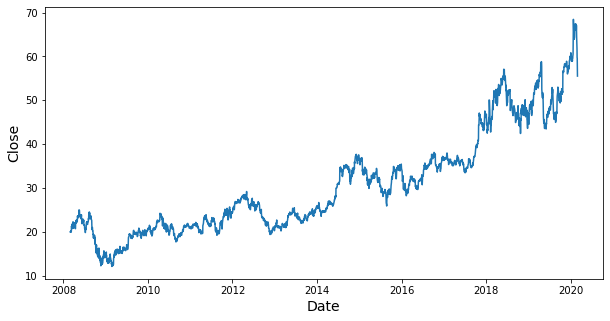

In [43]:
plt.figure(figsize=(10,5))

plt.plot(intel)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Close', fontsize = 14)
plt.show()

We will not be doing any further Exploratory Data Analysis and go (upon rescaling) straight to training the corresponding RNN model. The subsequent investigation shows that it is significantly harder to achieve accurate predictions once the series is noisy and stationary, at least within the framework in which only historical prices are used. 

We find also that it is much more appropriate to use MinMaxScaler rather than StandardScaler in this case.

In [44]:
intel_train = intel[intel.index < '2019-03-01']

intel_test =  intel[intel.index >= '2019-03-01']

#scaler1 = StandardScaler()
scaler1 = MinMaxScaler()

scaler1.fit(intel_train[['Close']])

intel_train['Close_scaled'] = scaler1.transform(intel_train[['Close']])

intel_test['Close_scaled'] = scaler1.transform(intel_test[['Close']])

print("Training set size: ",intel_train.index.size)
print("Test set size: ", intel_test.index.size)

Training set size:  2769
Test set size:  252


C:\Users\ddali\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\ddali\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


We then create the train and test datasets exactly as we did for Apple. The TIMESTEP is equal to 10.

In [45]:
TIMESTEP = 10 # number of timesteps in the sequence

In [46]:
X_train, y_train = DatasetCreation(np.array(intel_train.Close_scaled), TIMESTEP)
 
#reshape training set according to the form specified above     
X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEP, 1))  

# add extra dimension to y
y_train = np.expand_dims(y_train, axis=1)


inputs = pd.concat([intel_train['Close_scaled'], intel_test['Close_scaled']], axis =0)\
         .iloc[len(intel.index) - len(intel_test.index)-TIMESTEP:]

X_test, y_test = DatasetCreation(np.array(inputs), TIMESTEP)
 
#reshape test set according to the form specified above     
X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEP, 1))  

# add extra dimension to y
y_test = np.expand_dims(y_test, axis=1)


print(X_train.shape,  y_train.shape)
print(X_test.shape,  y_test.shape)

(2759, 10, 1) (2759, 1)
(252, 10, 1) (252, 1)


### LSTM for Intel 

We then use the Recurrent Neural Network architecture consisting of three LSTM layers with 80 nodes each. The initial learning rate is chosen, however, equal to 0.0030 and decays according to the same functional form INITIAL_LR * 0.97 ** epoch.

In [47]:
HIDDEN_SIZE = 80 # number of the elements in the hidden layer to serve as hyperparameter


model = Sequential()   
model.add(LSTM(HIDDEN_SIZE, activation = 'tanh', input_shape=(TIMESTEP, 1), 
               kernel_initializer = glorot_uniform(seed=123), 
               recurrent_initializer = Orthogonal(seed=123),
                       return_sequences = True))



model.add(LSTM(HIDDEN_SIZE, activation = 'tanh', kernel_initializer = glorot_uniform(seed=123), 
               recurrent_initializer = Orthogonal(seed=123), return_sequences = True))

#model.add(LSTM(HIDDEN_SIZE, activation = 'tanh', kernel_initializer = glorot_uniform(seed=123), 
#               recurrent_initializer = Orthogonal(seed=123), return_sequences = True))

model.add(LSTM(HIDDEN_SIZE, activation = 'tanh', kernel_initializer = glorot_uniform(seed=123), 
               recurrent_initializer = Orthogonal(seed=123), return_sequences = False))


model.add(Dense(1, kernel_initializer=glorot_uniform(seed=123)))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 80)            26240     
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 80)            51520     
_________________________________________________________________
lstm_6 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 81        
Total params: 129,361
Trainable params: 129,361
Non-trainable params: 0
_________________________________________________________________


In [48]:
#initial learning rate
INITIAL_LR = 0.0030

OPTIMIZER = RMSprop(lr=INITIAL_LR)

model.compile(loss='mean_squared_error', optimizer= OPTIMIZER, metrics = ['mse'])

# learning rate decay
def lr_decay(epoch):
    return INITIAL_LR * 0.97 ** epoch


checkpoint = ModelCheckpoint('model_intel_weights.h5', monitor='mse', 
                            verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint, LearningRateScheduler(lr_decay)]

In [49]:
%%time

NUM_EPOCHS = 450  # number of epochs

BATCH_SIZE =  32  # batch size

VERBOSE = 1

# !!!it is important that we do not shuffle data

history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=False, 
                                  verbose = VERBOSE, callbacks = callbacks_list)

Epoch 1/450
2759/2759 [==============================] - 5s 2ms/step - loss: 0.0145 - mse: 0.0145

Epoch 00001: mse improved from inf to 0.01450, saving model to model_intel_weights.h5
Epoch 2/450
2759/2759 [==============================] - 4s 1ms/step - loss: 0.0106 - mse: 0.0106

Epoch 00002: mse improved from 0.01450 to 0.01057, saving model to model_intel_weights.h5
Epoch 3/450
2759/2759 [==============================] - 4s 1ms/step - loss: 0.0101 - mse: 0.0101

Epoch 00003: mse improved from 0.01057 to 0.01010, saving model to model_intel_weights.h5
Epoch 4/450
2759/2759 [==============================] - 4s 1ms/step - loss: 0.0095 - mse: 0.0095

Epoch 00004: mse improved from 0.01010 to 0.00945, saving model to model_intel_weights.h5
Epoch 5/450
2759/2759 [==============================] - 4s 2ms/step - loss: 0.0097 - mse: 0.0097

Epoch 00005: mse did not improve from 0.00945
Epoch 6/450
2759/2759 [==============================] - 5s 2ms/step - loss: 0.0070 - mse: 0.0070A: 0s 

Epoch 43/450
2759/2759 [==============================] - 4s 1ms/step - loss: 2.9850e-04 - mse: 2.9850e-04

Epoch 00043: mse improved from 0.00031 to 0.00030, saving model to model_intel_weights.h5
Epoch 44/450
2759/2759 [==============================] - 4s 1ms/step - loss: 2.8822e-04 - mse: 2.8822e-04

Epoch 00044: mse improved from 0.00030 to 0.00029, saving model to model_intel_weights.h5
Epoch 45/450
2759/2759 [==============================] - 4s 1ms/step - loss: 2.7811e-04 - mse: 2.7811e-04

Epoch 00045: mse improved from 0.00029 to 0.00028, saving model to model_intel_weights.h5
Epoch 46/450
2759/2759 [==============================] - 4s 1ms/step - loss: 2.6895e-04 - mse: 2.6895e-04

Epoch 00046: mse improved from 0.00028 to 0.00027, saving model to model_intel_weights.h5
Epoch 47/450
2759/2759 [==============================] - 4s 1ms/step - loss: 2.6039e-04 - mse: 2.6039e-04

Epoch 00047: mse improved from 0.00027 to 0.00026, saving model to model_intel_weights.h5
Epoch 48/4

2759/2759 [==============================] - 4s 1ms/step - loss: 1.5031e-04 - mse: 1.5031e-04

Epoch 00086: mse improved from 0.00015 to 0.00015, saving model to model_intel_weights.h5
Epoch 87/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.4911e-04 - mse: 1.4911e-04

Epoch 00087: mse improved from 0.00015 to 0.00015, saving model to model_intel_weights.h5
Epoch 88/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.4800e-04 - mse: 1.4800e-04

Epoch 00088: mse improved from 0.00015 to 0.00015, saving model to model_intel_weights.h5
Epoch 89/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.4697e-04 - mse: 1.4697e-04

Epoch 00089: mse improved from 0.00015 to 0.00015, saving model to model_intel_weights.h5
Epoch 90/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.4602e-04 - mse: 1.4602e-04A: 

Epoch 00090: mse improved from 0.00015 to 0.00015, saving model to model_intel_weights.h5
Epoch 91/450
2759/27

2759/2759 [==============================] - 4s 1ms/step - loss: 1.3835e-04 - mse: 1.3835e-04

Epoch 00126: mse improved from 0.00014 to 0.00014, saving model to model_intel_weights.h5
Epoch 127/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3822e-04 - mse: 1.3822e-04

Epoch 00127: mse improved from 0.00014 to 0.00014, saving model to model_intel_weights.h5
Epoch 128/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3809e-04 - mse: 1.3809e-04

Epoch 00128: mse improved from 0.00014 to 0.00014, saving model to model_intel_weights.h5
Epoch 129/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3796e-04 - mse: 1.3796e-04

Epoch 00129: mse improved from 0.00014 to 0.00014, saving model to model_intel_weights.h5
Epoch 130/450
2759/2759 [==============================] - 3s 1ms/step - loss: 1.3783e-04 - mse: 1.3783e-04

Epoch 00130: mse improved from 0.00014 to 0.00014, saving model to model_intel_weights.h5
Epoch 131/450
2759/

2759/2759 [==============================] - 5s 2ms/step - loss: 1.3451e-04 - mse: 1.3451e-04A: 0s - loss: 9.6502e-05 - mse: 9.6

Epoch 00166: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 167/450
2759/2759 [==============================] - 4s 2ms/step - loss: 1.3446e-04 - mse: 1.3446e-04

Epoch 00167: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 168/450
2759/2759 [==============================] - 4s 2ms/step - loss: 1.3441e-04 - mse: 1.3441e-04

Epoch 00168: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 169/450
2759/2759 [==============================] - 4s 2ms/step - loss: 1.3437e-04 - mse: 1.3437e-04A: 0s - loss: 1.2970e-04 - mse: 1.2970e-

Epoch 00169: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 170/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3432e-04 - mse: 1.3432e-04

Epoch 00170: mse improved from 0.0

Epoch 207/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3334e-04 - mse: 1.3334e-04

Epoch 00207: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 208/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3332e-04 - mse: 1.3332e-04

Epoch 00208: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 209/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3331e-04 - mse: 1.3331e-04A: 2s - loss

Epoch 00209: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 210/450
2759/2759 [==============================] - 4s 2ms/step - loss: 1.3329e-04 - mse: 1.3329e-04

Epoch 00210: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 211/450
2759/2759 [==============================] - 4s 2ms/step - loss: 1.3328e-04 - mse: 1.3328e-04

Epoch 00211: mse improved from 0.00013 to 0.00013, saving model to model_intel_weig

2759/2759 [==============================] - 4s 1ms/step - loss: 1.3285e-04 - mse: 1.3285e-04

Epoch 00247: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 248/450
2759/2759 [==============================] - 4s 2ms/step - loss: 1.3284e-04 - mse: 1.3284e-04A: 1s - loss: 7.9345e-05 

Epoch 00248: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 249/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3283e-04 - mse: 1.3283e-04

Epoch 00249: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 250/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3282e-04 - mse: 1.3282e-04

Epoch 00250: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 251/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3281e-04 - mse: 1.3281e-04

Epoch 00251: mse improved from 0.00013 to 0.00013, saving model to model_intel_weigh

2759/2759 [==============================] - 5s 2ms/step - loss: 1.3259e-04 - mse: 1.3259e-04

Epoch 00286: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 287/450
2759/2759 [==============================] - 4s 2ms/step - loss: 1.3258e-04 - mse: 1.3258e-04

Epoch 00287: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 288/450
2759/2759 [==============================] - 5s 2ms/step - loss: 1.3258e-04 - mse: 1.3258e-04A: 2s

Epoch 00288: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 289/450
2759/2759 [==============================] - 4s 2ms/step - loss: 1.3258e-04 - mse: 1.3258e-04

Epoch 00289: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 290/450
2759/2759 [==============================] - 4s 2ms/step - loss: 1.3257e-04 - mse: 1.3257e-04

Epoch 00290: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 291/450


2759/2759 [==============================] - 3s 1ms/step - loss: 1.3249e-04 - mse: 1.3249e-04

Epoch 00326: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 327/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3249e-04 - mse: 1.3249e-04

Epoch 00327: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 328/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3249e-04 - mse: 1.3249e-04

Epoch 00328: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 329/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3249e-04 - mse: 1.3249e-04

Epoch 00329: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 330/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3249e-04 - mse: 1.3249e-04

Epoch 00330: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 331/450
2759/

Epoch 367/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3246e-04 - mse: 1.3246e-04

Epoch 00367: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 368/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3246e-04 - mse: 1.3246e-04

Epoch 00368: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 369/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3246e-04 - mse: 1.3246e-04

Epoch 00369: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 370/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3246e-04 - mse: 1.3246e-04

Epoch 00370: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 371/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3245e-04 - mse: 1.3245e-04

Epoch 00371: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch

2759/2759 [==============================] - 4s 2ms/step - loss: 1.3245e-04 - mse: 1.3245e-04

Epoch 00410: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 411/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3244e-04 - mse: 1.3244e-04A: 1s - loss: 8.5386e-05 - 

Epoch 00411: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 412/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3244e-04 - mse: 1.3244e-04

Epoch 00412: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 413/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3244e-04 - mse: 1.3244e-04

Epoch 00413: mse improved from 0.00013 to 0.00013, saving model to model_intel_weights.h5
Epoch 414/450
2759/2759 [==============================] - 4s 1ms/step - loss: 1.3244e-04 - mse: 1.3244e-04

Epoch 00414: mse improved from 0.00013 to 0.00013, saving model to model_intel_wei

Wall time: 30min 16s


We then evaluate our model on the train set and plot the behavior of the loss as a function of epoch number.

Keras Model Loss =  0.000132429099795287


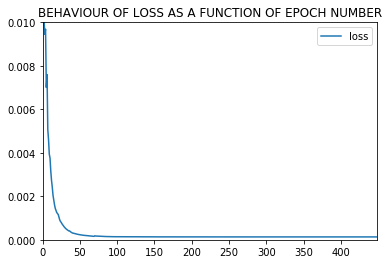

In [50]:
score = model.evaluate(X_train, y_train, verbose=0)
print('Keras Model Loss = ',score[0])


metrics_df = pd.DataFrame(data={"loss": history.history['loss']})
#metrics_df

fig1 = metrics_df.plot(title ='BEHAVIOUR OF LOSS AS A FUNCTION OF EPOCH NUMBER',
                      ylim = (0, 0.01)).\
get_figure()

plt.show()

fig1.savefig('loss_intel.pdf')

### Predictions on the test set and comparison with the actual prices for Intel

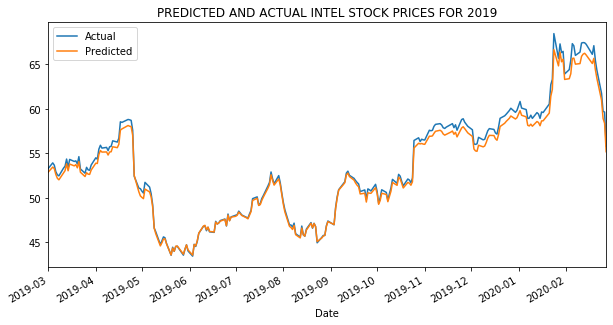

In [51]:
y_pred = model.predict(X_test)

y_pred = scaler1.inverse_transform(y_pred)
y_pred = np.squeeze(y_pred, axis = 1)

ind = intel_test.index

pred_df = pd.DataFrame(data={'Actual': intel_test['Close'][:-1], 
                                    'Predicted': y_pred[1:]}, index = ind[:-1])

fig2 = pred_df.plot(figsize=(10,5),
                    title = 'PREDICTED AND ACTUAL INTEL STOCK PRICES FOR 2019').get_figure()
plt.show()

fig2.savefig('predicted_prices_intel.pdf')

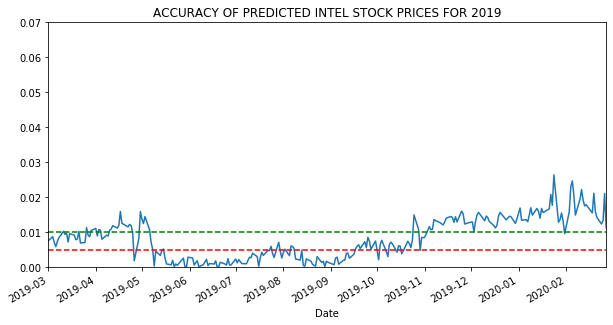

In [52]:
pred_df['Accuracy'] = np.abs(pred_df['Actual'] - \
                                    pred_df['Predicted'])/pred_df['Actual']

fig3 = pred_df['Accuracy'].plot(title = 'ACCURACY OF PREDICTED INTEL STOCK PRICES FOR 2019', 
                                  figsize=(10,5), ylim = (0, 0.07)).get_figure()

plt.axhline(y=.005, ls = 'dashed', c = 'r')
plt.axhline(y=.01, ls = 'dashed', c = 'g')

plt.show()

fig3.savefig('accuracy_of_prediction_intel.pdf')

The plots above show that predictions are best during first 8 months. Beyond this period the accuracy drops. One can see that the accuracy of predicted Intel stock prices lies in most places within the one percent range during the first 8 months (apart from some regions with even lower accuracy). Similar to the case of Apple stocks, our model catches the trends in changing the prices quite well at least for earlier moments of time. Despite significant efforts, however, I was not able to achieve the overall accuracy of predictions for Intel that is as high as that for Apple.     

## Conclusion 

The RNN model consisting of LSTM layers were used to predict the stock prices of Intel and Apple companies. For each company, the prediction of prices for the period of one year (from 03-01-2019 to 03-01-2020) were made solely based on the actual prices observed during the previous 11 years for the same company. No other parameters were used as inputs. One can conclude that the tested model works better if the time series describing stock prices is less noisy and more non-stationary. It remains to be seen whether additional parameters obtained as a result of feature engineering (e.g. rolling means and standard deviations of prices), as well as parameters extracted from external datasets related to tendencies in price fluctuations, can increase the accuracy of predictions.      